In [1]:
import pandas as pd
import easyocr 
import sys
import numpy as np
sys.path.append('C:/IDE/repository/liquid_vapor_database')
from src.pdf_image_extractor import PDFImageExtractor
from src.pdf_page_processor import PageImage
from src.page_data import PageData
from src.cropped_tables import CroppedTables


PAGE_NUM = 318
data_path = f'C:/IDE/repository/liquid_vapor_database/data/Kogan_1.pdf'
work_folder_path = f'C:/IDE/repository/liquid_vapor_database/pdf_data/page_{PAGE_NUM}'
assets_folder_path = 'C:/IDE/repository/liquid_vapor_database/tests/assets'
img_path = f'{work_folder_path}/page_{PAGE_NUM}_processed.png'
extractor = PDFImageExtractor(data_path, work_folder_path)
page_image = PageImage(PAGE_NUM, extractor)
reader = easyocr.Reader(['ru', 'en'])
result = reader.readtext(img_path)
easyocr_df = pd.DataFrame(result, columns=['bbox','text','conf'])
page = PageData(easyocr_df)
page.df.to_csv(f'{assets_folder_path}/{PAGE_NUM}_df.csv', index=False)
cropped_tables = CroppedTables(page, img_path, work_folder_path)

Обработка страницы 318


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Метод isolate_dark_shades выполнен


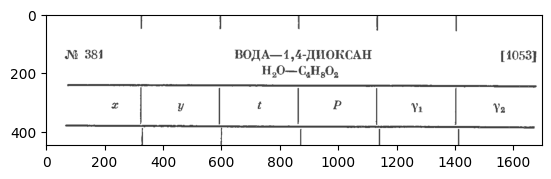

In [16]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread(cropped_tables.metadata[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.imshow(img)

In [2]:
import pytesseract
import os
import cv2


img_path = f'{work_folder_path}/page_{PAGE_NUM}_processed.png'

def clean_and_format_text(text, blacklist):
    cleaned_lines = []
    for line in text.split('\n'):
        for char in blacklist:
            line = line.replace(char, '')  # Удаляем символы из черного списка
        cleaned_line = ','.join(line.split())  # Замена пробелов на запятые
        cleaned_lines.append(cleaned_line)
    return '\n'.join(cleaned_lines)

def extract_text_from_images(img_path, custom_config=r'--oem 3 --psm 6'):
    csv_path = work_folder_path + '/values.csv'
    blacklist = ['{', '}', '|']
    if os.path.exists(img_path):
        img = cv2.imread(img_path) 
        text = pytesseract.image_to_string(img, config=custom_config, lang='rus+eng')
        cleaned_text = clean_and_format_text(text, blacklist)
        with open(csv_path, 'w', encoding='utf-8') as text_file:
            text_file.write(cleaned_text)
            
            

extract_text_from_images(cropped_tables.value[0])

In [3]:
def convert_to_float(value):
    try:
        # Пытаемся сначала конвертировать напрямую
        return float(value)
    except ValueError:
        # Если не удаётся, удаляем символы из черного списка и пытаемся снова
        for char in ['*', '%']:
            value = value.replace(char, '')
        try:
            return float(value)
        except ValueError:
            # Если конвертация снова не удаётся, возвращаем исходное значение
            return value

csv_path = work_folder_path + '/values.csv'
_df = pd.read_csv(csv_path, header=None)
_df = _df.apply(lambda col: col.map(convert_to_float))
_df

,0,1,2,3,4,5
0,0.00,0.00,30.00,60.050,—,1.0
1,10.70,27.53,74.62,4.526,1.008,NaN
2,11.40,26.85,75.37,4.163,1.036,NaN
3,19.55,32.10,79.18,3.049,1.113,NaN
4,30.20,35.70,81.30,2.254,1.246,NaN
5,46.25,37.50,80.21,1.545,1.544,NaN
6,57.60,40.50,80.60,1.328,1.882,NaN
7,61.95,41.65,80.61,1.273,2.058,NaN
8,63.65,42.10,80.00,1.258,2.1,NaN
9,71.25,46.30,78.14,1.158,2.488,NaN


In [5]:
result = reader.readtext(cropped_tables.value[1], allowlist='0123456789.-*')
easyocr_df = pd.DataFrame(result, columns=['bbox','text','conf'])
page = PageData(easyocr_df)
df = page.df.drop(['region','prev_region','next_region','table_number'], axis=1)
# Function to process each column
def process_column(column):
    # Extract the first element from each list, or None if the list is empty
    processed_column = [item[0] if isinstance(item, list) and len(item) > 0 else None for item in column]
    # Remove None values
    return [item for item in processed_column if item is not None]

# Process each column and rebuild the DataFrame
processed_data = {col: process_column(df[col]) for col in df.columns}
processed_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in processed_data.items()])).dropna(axis=1, how='all')

def convert_to_float(value):
    try:
        # Пытаемся сначала конвертировать напрямую
        return float(value)
    except ValueError:
        # Если не удаётся, удаляем символы из черного списка и пытаемся снова
        for char in ['*', '%']:
            value = value.replace(char, '')
        try:
            return float(value)
        except ValueError:
            # Если конвертация снова не удаётся, возвращаем исходное значение
            return value

# Применяем функцию ко всем элементам DataFrame
processed_df = processed_df.apply(lambda col: col.map(convert_to_float))
processed_df

,0,1,2,3,4,5
0,,15.4,25.0,42.7,5.56,1.03
1,NaN,24.1,NaN,45.2,4.56,1.03
2,NaN,30.9,NaN,95.0,2.57,1.14
3,NaN,36.9,NaN,43.9,1.66,2.62
4,NaN,44.0,NaN,37.5,1.05,2.90
5,NaN,56.0,NaN,30.0,0.99,4.06
6,NaN,77.0,NaN,NaN,1.01,4.67


In [6]:
df

,0,1,2,3,4,5,6
0,[],[],[],[],[],[],[]
1,[],[15.4],[25],[42.7],[],[],[]
2,[],[],[],[],[5.56],[1.03],[]
3,[],[],[],[],[],[],[]
4,[],[24.1],[],[45.2],[],[],[]
5,[],[],[],[],[4.56],[1.03],[]
6,[],[],[],[],[],[],[]
7,[],[30.9],[],[],[],[],[]
8,[],[],[],[],[2.57],[1.14],[]
9,[],[],[],[],[],[],[]


In [15]:
def find_missing_elements(df1, df2):
    # Подсчет элементов в df1
    count_df1 = pd.Series(df1.values.ravel()).value_counts().to_dict()

    # Подсчет элементов в df2
    count_df2 = pd.Series(df2.values.ravel()).value_counts()

    # Нахождение элементов, количество которых не совпадает
    missing_elements = {}
    for value, count in count_df1.items():
        count_in_df2 = count_df2.get(value, 0)
        if count != count_in_df2:
            missing_elements[value] = {'df1': count, 'df2': count_in_df2}

    return missing_elements

missing = find_missing_elements(processed_df, _df)
for value, counts in missing.items():
    print(f"Значение: {value}, Количество в df1: {counts['df1']}, Количество в df2: {counts['df2']}")

Значение: 102.0, Количество в df1: 4, Количество в df2: 3
Значение: 47.7, Количество в df1: 2, Количество в df2: 1
Значение: 93.5, Количество в df1: 2, Количество в df2: 1
Значение: 59.1, Количество в df1: 1, Количество в df2: 0
Значение: 71.7, Количество в df1: 1, Количество в df2: 0
Значение: 12.1, Количество в df1: 1, Количество в df2: 0
Значение: 23.1, Количество в df1: 1, Количество в df2: 0


In [ ]:
def align_dataframes(df1, df2):
    # Step 1: Validate DataFrames
    if df1.shape != df2.shape:
        raise ValueError("The shapes of df1 and df2 do not match.")

    # Step 2: Create a New DataFrame
    df_final = pd.DataFrame(index=df1.index, columns=df1.columns)
    for column in df1.columns:
        for idx in df1.index:
            value = df1.at[idx, column]
            # Find correct position for this value in df2 and place it in df_final
            correct_row = find_correct_row(value, df2, column)
            df_final.at[correct_row, column] = value

    # Step 3: Return df_final
    return df_final

def find_correct_row(value, df, column):
    # This function will find the row in df where 'value' belongs
    for idx in df.index:
        if df.at[idx, column] == value:
            return idx
        
df_final = align_dataframes(processed_df, _df)

df_final

In [3]:
import pytesseract

img_path = cropped_tables.value[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = reader.readtext(img_path, allowlist='0123456789.-')
easyocr_df = pd.DataFrame(result, columns=['bbox','text','conf'])
page = PageData(easyocr_df)
min_width, max_width = page.unscale_width_position(1, 2)
cropped_img = img[:, min_width:max_width, :]
text = pytesseract.image_to_string(cropped_img, config=r'--oem 3 --psm 6', lang='rus+eng')
text


'31.74\n60.51\n76.65\n84.51\n87.35\n83.11\n57.02\n71.98\n83.40\n88.77\n91.06\n89.54\n77.81\n87.50\n92.63\n'

In [5]:
def parse_ocr_str(input_str):
    # Черный список символов для удаления
    blacklist = ['{', '}', '|']

    # Удаляем каждый символ из черного списка из входной строки
    for char in blacklist:
        input_str = input_str.replace(char, '')

    # Заменяем переносы строки на запятые
    input_str = input_str.replace('\n', ',')

    # Преобразуем строку в список, разделяя элементы по запятой
    values_list = input_str.split(',')

    # Удаляем пустые строки из списка
    values_list = [value for value in values_list if value]

    # Преобразуем список в pd.Series
    series = pd.Series(values_list)

    return series

###
img_path = cropped_tables.value[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

df = page.df.drop(['region','prev_region','next_region','table_number'], axis=1)

# Функция для проверки, является ли список пустым
is_empty = lambda x: len(x) == 0 if isinstance(x, list) else True

value_columns = [column for column in df.columns if not df[column].apply(is_empty).all()]

value_df = pd.DataFrame()
for column in value_columns:
    min_width, max_width = page.unscale_width_position(column, column + 1)
    cropped_img = img[:, min_width:max_width, :]
    text = pytesseract.image_to_string(cropped_img, config=r'--oem 3 --psm 6', lang='rus+eng')
    column_series = parse_ocr_str(text)
    value_df[column] = column_series

# # Проверяем, что количество столбцов четное
# if len(value_df.columns) % 2 != 0:
#     raise ValueError("Количество столбцов в DataFrame нечетное.")

# # Если столбцов больше 4, разделяем DataFrame и конкатенируем половины
# if len(value_df.columns) > 4:
#     mid_index = len(value_df.columns) // 2
#     first_half = value_df.iloc[:, :mid_index]
#     second_half = value_df.iloc[:, mid_index:]

#     # Переименовываем столбцы во второй половине, чтобы соответствовать первой половине
#     column_mapping = {second_half.columns[i]: first_half.columns[i] for i in range(mid_index)}
#     second_half.rename(columns=column_mapping, inplace=True)

#     # Конкатенация второй половины в конец первой
#     concatenated_df = pd.concat([first_half, second_half], ignore_index=True)

#     value_df = concatenated_df

In [16]:
import pytesseract
import os


img_path = f'{work_folder_path}/page_{PAGE_NUM}_processed.png'

def clean_and_format_text(text, blacklist):
    cleaned_lines = []
    for line in text.split('\n'):
        for char in blacklist:
            line = line.replace(char, '')  # Удаляем символы из черного списка
        cleaned_line = ','.join(line.split())  # Замена пробелов на запятые
        cleaned_lines.append(cleaned_line)
    return '\n'.join(cleaned_lines)

def extract_text_from_images(img_path, custom_config=r'--oem 3 --psm 6'):
    extracted_text_path = work_folder_path + '/values.csv'
    blacklist = ['{', '}', '|']
    if os.path.exists(img_path):
        img = cv2.imread(img_path) 
        text = pytesseract.image_to_string(img, config=custom_config, lang='rus+eng')
        cleaned_text = clean_and_format_text(text, blacklist)
        with open(extracted_text_path, 'w', encoding='utf-8') as text_file:
            text_file.write(cleaned_text)
            
            

extract_text_from_images(cropped_tables.value[1])

In [ ]:
def extract_text_from_images(self, custom_config=r'--oem 3 --psm 6 -c preserve_interword_spaces=1'):
        extracted_text_path = os.path.join(self.extractor.images_folder, f'{self.page_num}_text.txt')
        with open(extracted_text_path, 'w', encoding='utf-8') as text_file:                     
            img_path = os.path.join(self.extractor.images_folder, f'page_{self.page_num}_processed.png')
            if os.path.exists(img_path):
                # Адаптивная пороговая обработка и удаление "клякс"
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)                

                # OCR и сохранение текста
                text = pytesseract.image_to_string(img_path, config=custom_config, lang='rus+eng')
                text_file.write(f'--- Страница {self.page_num} ---\n{text}\n')
                self.text = pytesseract.image_to_data(img_path, output_type=pytesseract.Output.DICT, config=custom_config, lang='rus+eng')

In [14]:
diff = page_image.max_height - page.max_y 
_min, _max = page.unscale_height_position(temp_df.index.min(), temp_df.index.max())

def adjust_min_max(_min, _max, bbox_mean):    
    if (_min_adjusted := _min - bbox_mean) < 0:
        _min_adjusted = 0
        
    _max_adjusted = (_max + bbox_mean)

    return _min_adjusted, _max_adjusted

adjusted_min, adjusted_max = adjust_min_max(
    _min, _max, page.data['bbox_height'].mean().astype('int'))

print("Adjusted Min:", adjusted_min)
print("Adjusted Max:", adjusted_max)

Adjusted Min: 1922
Adjusted Max: 2489


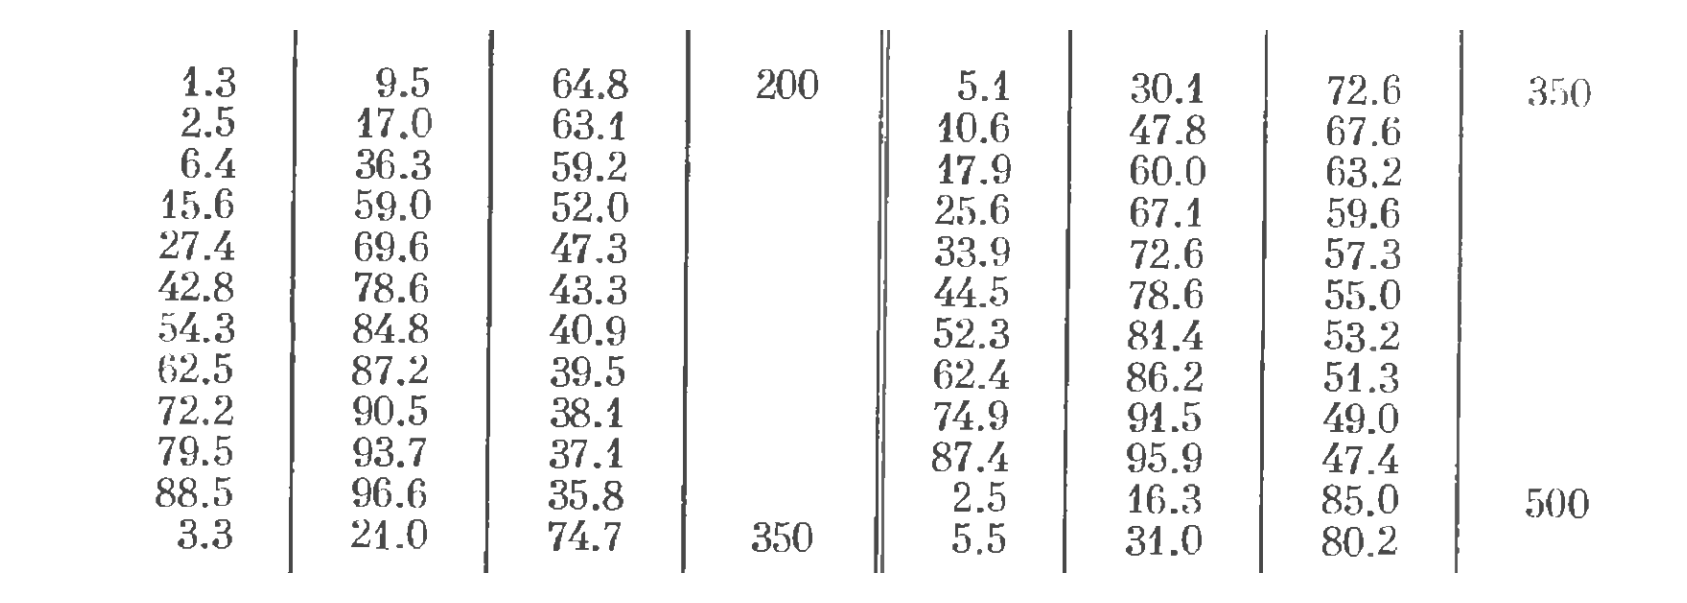

In [15]:
import matplotlib.pyplot as plt
import cv2


img = cv2.imread(img_path)

# Переключение цветовых каналов из BGR (формат OpenCV) в RGB (формат matplotlib).
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Обрезка изображения по высоте.
C = 0
cropped_img = img[adjusted_min - C:adjusted_max + C, :, :]

plt.figure(figsize=(7, 7), dpi=300)  
plt.imshow(cropped_img, interpolation='bilinear') 
plt.axis('off')
plt.show()

In [3]:
#page_image.min_width
page.unscale_height_position(temp_df.index.min(), temp_df.index.max())

(1704, 1960)

In [16]:
def crop_and_save_image(image_path, rectangles, save_dir):
    # Загрузка изображения
    img = cv2.imread(image_path)
    if img is None:
        print("Ошибка загрузки изображения. Проверьте путь к изображению.")
        return

    # Обрезка и сохранение каждого прямоугольника
    for i, (x1, y1, x2, y2) in enumerate(rectangles):
        # Обрезка изображения согласно координатам
        crop_img = img[y1:y2, x1:x2]

        # Сохранение обрезанного изображения
        save_path = f"{save_dir}/cropped_{i+1}.png"
        cv2.imwrite(save_path, crop_img)
        print(f"Сохранено: {save_path}")

save_dir = 'C:/IDE/repository/liquid_vapor_database/pdf_data/page_133'       
crop_and_save_image(img_path, blue_coords, save_dir)

Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_1.png
Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_2.png
Сохранено: C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/cropped_3.png


In [16]:
img_path

'C:/IDE/repository/liquid_vapor_database/pdf_data/page_170/page_170_processed.png'

In [10]:
import pandas as pd

# easyocr_df - предположим, что это ваш DataFrame с результатами OCR

# Пересчитать координаты для более простого доступа
easyocr_df['x_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][0])
easyocr_df['y_min'] = easyocr_df['bbox'].apply(lambda bbox: bbox[0][1])
easyocr_df['x_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][0])
easyocr_df['y_max'] = easyocr_df['bbox'].apply(lambda bbox: bbox[2][1])

# Сортировка по Y, затем по X координатам
sorted_df = easyocr_df.sort_values(by=['y_min', 'x_min'])

# Группировка текста по строкам с учетом допуска в Y координатах
grouped_lines = {}
line_threshold = 10  # допуск в пикселях для Y координаты, чтобы считать тексты одной строки

for _, row in sorted_df.iterrows():
    added = False
    for y in grouped_lines:
        if abs(y - row['y_min']) < line_threshold:
            grouped_lines[y].append((row['x_min'], row['text']))
            added = True
            break
            
    if not added:
        grouped_lines[row['y_min']] = [(row['x_min'], row['text'])]

# Формирование итогового текста с пробелами, соответствующими расстоянию между словами
output_text = []
for y in sorted(grouped_lines.keys()):
    texts = sorted(grouped_lines[y], key=lambda x: x[0])
    line_text = ""
    last_x_end = 0
    for x, text in texts:
        space_count = max((x - last_x_end) // 20 - len(text), 0)  # количество пробелов между словами
        line_text += ' ' * space_count + text
        last_x_end = x + len(text) * 20  # обновление последнего x конца с учетом добавленного текста
    output_text.append(line_text)

# Сохраняем строки в текстовый файл
with open("output_text.txt", "w", encoding="utf-8") as file:
    for line in output_text:
        file.write(line + "\n")


TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
import cv2
import numpy as np

# Замените это путем к вашему изображению
image_path = 'C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed.png'

# Загрузите изображение
img = cv2.imread(image_path)

# Предполагается, что easyocr_df - это ваш DataFrame
for index, row in easyocr_df.iterrows():
    bbox = row['bbox']
    text = row['text']

    # Находим координаты для текста: левый верхний угол и нижний правый
    (tl, tr, br, bl) = bbox
    tl = (int(tl[0]), int(tl[1]))
    br = (int(br[0]), int(br[1]))

    # Установите параметры для текста: шрифт, размер и т.д.
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (0, 0, 255) # красный цвет
    font_thickness = 1

    # Нанесите текст на изображение
    img = cv2.putText(img, text, tl, font, font_scale, font_color, font_thickness, cv2.LINE_AA)

# Сохранить результат в файл
cv2.imwrite('C:/IDE/repository/liquid_vapor_database/pdf_data/page_133/page_133_processed_easyocr.png', img)

True

In [17]:
easyocr_df['text'].to_list()

['Ni',
 '1(',
 'ВОДОРОД_МЕТАН',
 '[258]',
 'H2CH4',
 '?',
 '9',
 't',
 'Р, ата',
 'T',
 'Р , ата',
 '2.4',
 '96.8',
 '-182.7',
 '49',
 '6.4',
 '-163.0',
 '78',
 '3.6',
 '97.5',
 '76',
 '7.7',
 '94.2',
 '90',
 '5.0',
 '96.9',
 '102',
 '8.5',
 '93.6',
 '97',
 '6.4',
 '139',
 '8.7',
 '91.9',
 '103',
 '8.1',
 '96.8',
 '164',
 '11.1',
 '91.2',
 '138',
 '8.2',
 '96.4',
 '171',
 '11.9',
 '92.0',
 '141',
 '94.8',
 '206',
 '15.6',
 '91.0',
 '187',
 '9.7',
 '94,4',
 '221',
 '3.2',
 '86.9',
 '_151.0',
 '36',
 '94.7',
 '_169.9',
 '39',
 '6.3',
 '92.5',
 '77',
 '2.2',
 '96.4',
 '77',
 '9.2',
 '91.1',
 '96',
 '5.1',
 '96.1',
 '104',
 '9.9',
 '89.8',
 '112',
 '111',
 '11.6',
 '88.8',
 '140',
 '5.2',
 '7',
 '95.8',
 '146',
 '16.2',
 '87,7',
 '187',
 '10.5',
 '95.7',
 '175',
 '3.8',
 '85.5',
 '~146.0',
 '37',
 '13.8',
 '94.2',
 '234',
 '6.7',
 '87.4',
 '62',
 '3.3',
 '92.6',
 '_163.0',
 '32',
 '9.3',
 '89.3',
 '85',
 '4.2',
 '92.7',
 '49',
 '14.3',
 '86.9',
 '131',
 '5.8',
 '93.6',
 '66',
 'Ni',
 '11',